<a href="https://fabiandablander.com/r/Spike-and-Slab.html">Reference</a>

## Samples generation

We will now generate samples from a linear model

$$
\boldsymbol{y} = \boldsymbol{X}^T\boldsymbol{\beta} + \boldsymbol{\epsilon}
$$

where $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$ and some of the coefficients $\beta_i=0$ in order to test our sparsity inducing bayesian model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
n_samples = 10

# X shaped like (n_samples,n_features)
X = rng.random(size=(n_samples,5))*10

# beta shaped like (n_features)
betas = np.array([
    1.,
    -2.,
    0.,
    4.,
    0.
    ])

sigma = 1

# y shaped like (n_samples)
y = X @ betas + rng.randn((n_samples))*sigma

# Gibbs Sampling the Posterior distribution for a linear model with Spike and Slab prior

Usual likelihood model for linear regression:

$$
P(y|\beta,x) \sim \mathcal{N}(<\beta , x>,\sigma^2)
$$


## Spike and Slab prior

We want to somehow give a certain probability for the coefficient $\beta$ to be exactly zero: that would be the case if its prior distribution was a $\delta (\beta)$. So we construct a prior that's a "mixture" of such delta function and some other prior distribution the allows the parameter to span a whole range of values:

<img src="./img/spikeslab.png" width=300>

The way this is usually implemented is by building a hierarchical model in which we "modulate" the prior based on an additional random variable $Z \sim Ber(\theta)$, that is $Z=1$ with probability $\theta$ and $Z=0$ with probability $1-\theta$. This additional variable regulates the prior distribution for $\beta$:

$$
P(Z_i) \sim Ber(\theta_i) \\
P(\beta_i|Z_i=0) \sim \delta(\beta_i) \\
P(\beta_i|Z_i=1) \sim P_{slab}(\beta_i)
$$

or more conveniently

$$
P(\beta_i|Z_i) = (1-Z_i)\delta(\beta_i) + Z_i P_{slab}(\beta_i)
$$

Where we subscripted the variables with $i$ because they are the coefficients in a linear regression model; since, if $Z_i=0$, the $\beta_i$ is inevitably zero, we can model the likelihood like this:

$$
P(y | \boldsymbol{z} , \boldsymbol{x}, \boldsymbol{\beta}) \sim \mathcal{N} (<\boldsymbol{z} \circ \boldsymbol{\beta},\boldsymbol{x}>,\sigma^2)
$$

Where $\boldsymbol{z}=(z_0,z_1,\dots)$ is the bernoulli vector and $\circ$ denotes the element-wise product. Also, we assume the slab distribution to be a gaussian centered at the origin, much like the ridge regression prior:

$$
P_{slab} = \mathcal{N} (0,\sigma^2 \tau^2)
$$

We put $\sigma^2$ in there because we want the distribution for $\beta$ to scale like the outcome.

We assume the following conjugate priors for the parameters:

$$
\theta \sim Beta(a,b) \\
\sigma^2 \sim InverseGamma(\alpha_1,\alpha_2) \\
\tau^2 \sim InverseGamma(1/2,s^2/2)
$$

It is useful to recap the relations between the random variables in a DAG, in order to properly express the conditional probabilities in our hierarchical model:

<img src="./img/DAG.png" width=400>

This helps us in factorizing the joint probability distribution via $d$-separation: (we do not subscript $\sigma^2$ and $\tau^2$ because we infer the same prior for every coefficient and same noise on each $y$)

$$
P(y,\beta_i,z_i,\theta_i,\tau^2,\sigma^2) = P(y|\beta_i,\sigma^2)P(\sigma^2)P(\beta_i|z_i,\tau^2)P(z_i|\theta_i)P(\theta_i)P(\tau^2)
$$

As for the hyperparameters in our priors (gray bubbles in graph), we fix $a=b=1$ for the beta distribution, $\alpha_1=\alpha_2=0.01$ for the $\sigma^2$ distribution and $s=1/2$ for the $\tau^2$ distribution.

The conditional posterior distribution can be broken up with the aid once again of the DAG shown above: 

$$
P(\theta_i | y,\beta_i,z_i,\tau^2,\sigma^2) = P(\theta_i|z_i) \\
P(\tau^2 | y,\beta_i,z_i,\theta_i,\sigma^2) = P(\tau^2 | \beta_i,z_i) \\
P(\sigma^2 | y,\beta_i,z_i,\theta_i,\tau^2) = P(\sigma^2 | y,\beta_i) \\
P(z_i | y,\beta_i,\theta_i,\tau^2,\sigma^2) = P(z_i | \beta_i,\theta_i,\tau^2) \\
P(\beta_i|y,\theta_i,z_i,\tau^2,\sigma^2) = P(\beta_i | y, z_i,\tau^2,\sigma^2)
$$

These conditional probabilities are needed to perform Gibbs sampling of the posterior distribution for all of these parameters. Let's derive their expressions.

### $P(\theta_i|z_i)$

Using Bayes' theorem:

$$
P(\theta_i|z_i) = \frac{P(z_i|\theta_i)P(\theta_i)}{\int P(z_i|\theta_i)P(\theta_i) d\theta_i}
$$

Now recall that $z_i \sim Ber(\theta_i) = \theta_i^{z_i}(1-\theta_i)^{1-z_i}$, and that we established the beta distribution with parameters $a,b$ as the prior for $\theta_i$:

$$
P(\theta_i|z_i) = \frac{\theta_i^{z_i}(1-\theta_i)^{1-z_i}\frac{1}{B(a,b)}\theta_i^{a-1}(1-\theta_i)^{b-1} }{ \int \theta_i^{z_i}(1-\theta_i)^{1-z_i}\frac{1}{B(a,b)}\theta_i^{a-1}(1-\theta_i)^{b-1} d\theta_i}
$$

which is again a Beta distribution normalized:

$$
P(\theta_i|z_i) = \frac{\theta_i^{(a+z_i)-1}(1-\theta_i)^{(b+1 - z_i)-1}}{\int \theta_i^{(a+z_i)-1}(1-\theta_i)^{(b+1 - z_i)-1}d\theta_i}
$$

so

$$
P(\theta_i|z_i) \sim Beta(a+z_i,b+1-z_i)
$$

### $P(\tau^2|\beta_i,z_i)$

This also has a dependency on $z_i$ when marginalizing because $P(\beta_i)$ has a dependency on both the parameters.

$$
P(\tau^2|\beta_i,z_i)= \frac{P(\beta_i|\tau^2,z_i)P(\tau^2)P(z_i)}{\int P(\beta_i|\tau^2,z_i)P(\tau^2)P(z_i) d\tau^2} = \frac{P(\beta_i|\tau^2,z_i)P(\tau^2)}{\int P(\beta_i|\tau^2,z_i)P(\tau^2) d\tau^2}
$$

We will denote here and later the normalization constant with $Z$. Now, the conditional probability on $\beta_i$ has a dependency on $z_i$: in particular, if 

### $z_i = 1$

$$
P(\tau^2 | \beta_i,z_i=1) = \frac{1}{Z}(2\pi\sigma^2\tau^2)^{-1/2}\exp \left [ -\frac{\beta_i^2}{2\sigma^2\tau^2} \right ] \frac{(s^2/2)^{1/2}}{\Gamma (1/2)}(\tau^2)^{-1/2 - 1}\exp \left [ -\frac{s^2/2}{\tau^2} \right ] = \frac{1}{Z}P(\beta|\tau^2,z_i=1)P(\tau^2)
$$

Which, absorbing every term not dependend on $\tau^2$ into the normalization constant, is again an Inverse Gamma distribution, which is expected since it's the conjugate prior for the exponential distribution with known mean:

$$
P(\tau^2|\beta_i, z_i=1) \sim InverseGamma(\frac{1}{2} + \frac{1}{2},\frac{s^2}{2}+\frac{\beta^2}{2\sigma^2})
$$

### $z_i = 0$

In this case, $\beta_i=0$ always and we simply sample from the prior:

$$
P(\tau^2|\beta_i, z_i=0) \sim InverseGamma(\frac{1}{2},\frac{s^2}{2})
$$


So we can summarize the $P(\tau^2|\beta_i,z_i)$ as 

$$
P(\tau^2|\beta_i,z_i) \sim InverseGamma(\frac{1}{2} + z_i \frac{1}{2},\frac{s^2}{2}+z_i\frac{\beta^2}{2\sigma^2})
$$


### $P(\sigma^2|y,\beta_i)$

Since $P(\sigma^2)\sim InverseGamma$, and from the likelihood probability of $\boldsymbol{y}$, we have

$$
\begin{align}
P(\sigma^2|y,\beta_i) &= \frac{1}{Z}P(y|\sigma^2,\beta_i)P(\sigma^2) \\
&= \frac{1}{Z} (2\pi\sigma^2)^{-n/2} \exp {\left[-\frac{1}{2\sigma^2} \sum_i^n (y_i - <\boldsymbol{\beta},\boldsymbol{x}_i>)^2 \right]}\frac{\alpha_2^{\alpha_1}}{\Gamma(\alpha_1)}(\sigma^2)^{-\alpha_1 -1 }\exp{\left[-\frac{\alpha_2}{\sigma^2}\right]}
\end{align}
$$

by absorbing every term that's not dependent on $\sigma^2$, we can rewrite this as

$$
P(\sigma^2|y,\beta_i) = \frac{1}{Z} (\sigma^2)^{-(\alpha_1 + \tfrac{n}{2})-1} \exp{ \left [ -\frac{1}{\sigma^2} \left( \alpha_2 + \frac{\sum_i^n (y_i-<\boldsymbol{\beta},\boldsymbol{x}_i>)^2}{2} \right ) \right ]}
$$

Which is again a Inverse Gamma, the conjugate prior for the gaussian likelihood: 

$$
P(\sigma^2|y,\beta_i) \sim Gamma \left ( \alpha_1 + \tfrac{n}{2},  \alpha_2 + \frac{\sum_i^n (y_i-<\boldsymbol{\beta},\boldsymbol{x}_i>)^2}{2} \right )
$$

Surprisingly, our posterior distribution for $\sigma^2$ gets updated with data points, but the distribution for $\tau^2$ does not, and instead is only dependent on the parameters $\beta$.

### $P(\beta|y,z,\tau^2,\sigma^2)$

We know that, when $z_i = 0$, the distribution collapses to the delta function centered at zero.
What about $z_i = 1$?

$$
\begin{align}
P(\beta|y,z=1,\tau^2,\sigma^2) & = \frac{P(y|\beta,z=1,\tau^2,\sigma^2)P(\beta|z=1)P(z=1)P(\tau^2)}{\int P(y|\beta,z=1,\tau^2,\sigma^2)P(\beta|z=1)P(z=1)P(\tau^2) d\beta} 
\end{align}
$$

By simplifying the terms that do not depend on $\beta$ and denoting with $Z$ again the normalization factor, we get

$$
P(\beta|y,z=1,\tau^2,\sigma^2) = \frac{1}{Z} (2\pi\sigma^2)^{-n/2} \exp {\left [ -\frac{1}{2\sigma^2} \sum_i^n(y_i - <\boldsymbol{\beta},\boldsymbol{x}_i>)^2 \right ]}(2\pi\sigma^2\tau^2)^{-1/2} \exp {\left [ -\frac{1}{2\sigma^2\tau^2} \beta \right ]}
$$

In [18]:
from scipy.stats import beta,gamma,multivariate_normal,binom,mode
from alive_progress import alive_bar # package to print the pretty progress bar. can be installed with pip install alive-progress


def sampling(y,X,a1=0.01,a2=0.01,theta=0.5,a=1.,b=10.,s=0.5,chain_samples=5000,nr_burnin=1500):

    n_samples = X.shape[0]
    n_features = X.shape[1]

    # dictionary of empty arrays to store different samples
    res = {
        "beta" : np.empty((chain_samples,n_features)),
        "z" : np.empty((chain_samples,n_features)),
        "sigma2" : np.empty(chain_samples),
        "tau2" : np.empty(chain_samples),
        "theta" : np.empty(chain_samples)
    }

    tau_fixed = 1.

    # initialize the masking as ones
    # OR ZEROS????
    res["z"][0] = np.zeros(n_features)
    # initialize the beta as least square regression
    res["beta"][0] = np.linalg.lstsq(X,y,rcond=None)[0]
    # initialize the sigma as the variance of the residuals
    res["sigma2"][0] = np.var(y - X @ res["beta"][0])
    # initialize the tau2 as one and the theta as 0.5
    res["tau2"][0] = tau_fixed
    res["theta"][0] = 0.5

    # compute only once
    XtX = X.T @ X
    Xty = X.T @ y

    # ----------------- BEGIN SAMPLING
    with alive_bar(chain_samples-1,force_tty=True) as bar:

        for i in range(1,chain_samples):


            # lets retrieve the previous values for easier coding
            z_prev = res["z"][i-1]
            beta_prev = res["beta"][i-1]
            sigma2_prev = res["sigma2"][i-1]
            tau2_prev = res["tau2"][i-1]
            theta_prev = res["theta"][i-1]

            # ------------------ LETS GO WITH THE CONDITIONALS

            # sample theta from a Beta distribution
            theta_new = beta.rvs(a + np.sum(z_prev),b+np.sum(1-z_prev))

            # sample sigma2 from an inverse gamma
            err = y - X @ beta_prev
            scale = 1./(a2 + (err.T @ err)/2)

            #---------------------------------- LETS TRY TO FIX SIGMA
            # sigma2_new = 1./gamma.rvs(a1+n_samples/2,scale=scale)
            sigma2_new=sigma2_prev

            # sample tau2 from an inverse gamma
            # scale = 1./((s**2)/2 + (beta_prev.T @ beta_prev)/(2*sigma2_new))

            # ------------------------------------- LETS TRY TO FIX TAU

            tau2_new = tau_fixed
            # tau2_new = 1./gamma.rvs(0.5+0.5*np.sum(z_prev),scale=scale)

            # sample new beta from a multivariate gaussian
            covariance = np.linalg.inv(XtX/sigma2_new + np.eye(n_features)/(sigma2_new*tau2_new))
            mean = covariance @ Xty /sigma2_new # is this right?
            beta_new = multivariate_normal.rvs(mean = mean,cov=covariance)

            # now we sample the zjs
            # in random order
            for j in np.random.permutation(n_features):
                
                # grab the current vector
                z0 = z_prev
                # set j to zero
                z0[j] = 0.
                # get the beta_{-j}
                bz0 = beta_new * z0

                # compute the u variables (one for each sample)
                xj = X[:,j] # the jth feature of each sample
                u = y - X @ bz0 
                cond_var = np.sum(xj**2) + 1./tau2_new

                # compute the chance parameter:
                # the probability of extracting zj = 0 is prop to (1-theta)
                # while of extracting zj=1 is (.....) mess 
                # computing the logarithm of these (l0 and l1) means that the probability of extracting zj=1 is
                # xi = exp(l1)/(exp(l1)+exp(l0))
                # we can also write this as
                # xi = 1/(1+ exp(l0-l1))
                # this way we can check if exp(l0-l1) overflows and just call it xi = 0

                l0 = np.log(1-theta_new)
                l1 = np.log(theta_new) \
                    - 0.5 * np.log(tau2_new*sigma2_new) \
                    + (np.sum(xj*u)**2)/(2*sigma2_new*cond_var) \
                    + 0.5*np.log(sigma2_new/cond_var)

                el0_l1 = np.exp(l0-l1)
                if np.isinf(el0_l1):
                    xi = 0
                else:
                    xi = 1/(1+el0_l1)
                
                # extract the zj
                z_prev[j]=binom.rvs(1,xi)

            # once we extracted all zj, store them:
            z_new = z_prev

            # update everything

            res["z"][i] = z_new
            # res["beta"][i] = beta_new
            res["beta"][i] = beta_new*z_new
            res["sigma2"][i] = sigma2_new
            res["tau2"][i] = tau2_new
            res["theta"][i] = theta_new

            bar()

        # ---------- END SAMPLING

    for k in res.keys():
        res[k] = res[k][nr_burnin:]
    
    return res 

In [19]:
samples=sampling(y,X,chain_samples=10000,nr_burnin=2000)

|████████████████████████████████████████| 9999/9999 [100%] in 6.3s (1590.81/s)                                         


In [42]:
np.mean(mode(samples['z'])[0]*samples['beta'],axis=0)

array([ 9.22498540e-01, -1.60606102e+00,  0.00000000e+00,  3.74037163e+00,
       -1.85302619e-03])

Real linear coefficients
[ 1. -2.  0.  4.  0.]
Marginalized posterior mean of coefficients: 
[ 9.22498540e-01 -1.60606102e+00  1.34810040e-02  3.74037163e+00
 -1.85302619e-03]


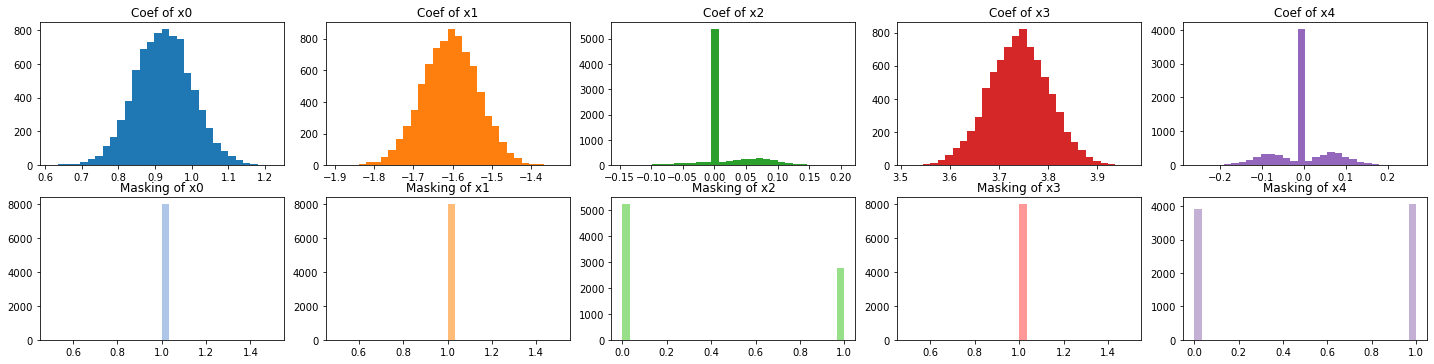

In [21]:
print("Real linear coefficients")
print(betas)

samples['z']==0

n_bins = 30
fig, axs = plt.subplots(2,5,figsize=[20,5])
colors=plt.get_cmap('tab20')
fig.tight_layout()
for i in range(5):
    axs[0,i].hist(samples['beta'][:,i],color=colors.colors[2*i],bins=n_bins)
    axs[0,i].set_title("Coef of x{}".format(i))
    axs[1,i].hist(samples['z'][:,i],color=colors.colors[2*i+1],bins=n_bins)
    axs[1,i].set_title("Masking of x{}".format(i))
